# Demo notebook: Differentiable programming for flexible gradient-based optimisation of statistical models: An exemplary modelling challenge

#### Maren Hackenberg 
#### Talk at the Workshop Statistical Computing, Reisensburg Castle
#### July 27, 2022

More extensive code, including scripts and a tutorial notebook, can be found in the [Github repository](https://github.com/maren-ha/DifferentiableProgrammingForStatisticalModeling) accompanying the TAS paper Hackenberg et al. (2021) ([journal version](https://doi.org/10.1080/00031305.2021.2002189), [arXiv:2021.05722](https://arxiv.org/abs/2012.05722)). 

The following notebook assumes you have downloaded the Github repo and [downloaded](https://julialang.org/downloads/) and installed Julia v1.6+. The required packages and their versions are specified in the `Project.toml` and `Manifest.toml` files in the main folder and automatically loaded/installed in the following commands. 

## Setup

In [7]:
path_to_repo = string(@__DIR__, "/../")

using Pkg;
# activate environment 
Pkg.activate(path_to_repo)

# install packages in versions specified in the Project.toml file 
Pkg.instantiate() 

# check that required package versions are there 
Pkg.status()

  Activating environment at `~/Desktop/TalkReisensburg/DifferentiableProgrammingForStatisticalModeling-main/Project.toml`


      Status `~/Desktop/TalkReisensburg/DifferentiableProgrammingForStatisticalModeling-main/Project.toml`
  [336ed68f] CSV v0.8.5
  [a93c6f00] DataFrames v1.1.1
  [5789e2e9] FileIO v1.9.0
  [38e38edf] GLM v1.4.2
  [033835bb] JLD2 v0.4.3
  [91a5bcdd] Plots v1.15.3
  [92933f4c] ProgressMeter v1.7.1
  [2913bbd2] StatsBase v0.33.8
  [f3b207a7] StatsPlots v0.14.21
  [112f6efa] VegaLite v2.6.0
  [e88e6eb3] Zygote v0.6.12
  [37e2e46d] LinearAlgebra
  [9a3f8284] Random
  [10745b16] Statistics


In [8]:
# import packages
using CSV 
using DataFrames
using FileIO
using GLM 
using JLD2
using LinearAlgebra
using ProgressMeter
using Random
using Statistics
using StatsBase
using StatsPlots
using VegaLite
using Zygote 

## Load data

We use data from the DIVI registry from April - June 2020 as an example. We load data from all hospitals in the registry in that time, specifically the current cases on each day, the information whether or not a report has been made on each day, and predicted incidences in the county of the hospital according to an SEIR model (for details, see [Refisch et al, 2022](https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-022-01579-9))

In [12]:
#load data  
datadict = load(string(@__DIR__,"/../data/data_allhospitals.jld2"))
hospital_list = datadict["hospital_dfs"]

1281-element Vector{Any}:
 70×5 DataFrame
 Row │ date        currentcases  notreported  reported  incidences 
     │ Date…       Float64       Bool         Bool      Float64    
─────┼─────────────────────────────────────────────────────────────
   1 │ 2020-04-16           0.0         true     false    11.5195
   2 │ 2020-04-17           0.0         true     false    11.0398
   3 │ 2020-04-18           0.0         true     false    10.5509
   4 │ 2020-04-19           0.0         true     false    10.0588
   5 │ 2020-04-20           0.0         true     false     9.5685
   6 │ 2020-04-21           0.0         true     false     9.0838
   7 │ 2020-04-22           0.0         true     false     8.60755
   8 │ 2020-04-23           0.0         true     false     8.1421
  ⋮  │     ⋮            ⋮             ⋮          ⋮          ⋮
  64 │ 2020-06-18           0.0        false      true     1.5568
  65 │ 2020-06-19           0.0        false      true     1.58805
  66 │ 2020-06-20           0.

## Visualize the number of reported cases over time 

In the following, we will take a look at an exemplary hospital (the one used to create the first figure in the talk and figures 1 and 2 in the manuscript), which can be found at index 40 in our dataset. 

Let's first look at the data. Note that the values shown in `:currentcases` have been imputed based on last-observation-carried-forward whenever a report has been missing, as indicated by a $0$ in the `:reported`column. 

In [14]:
myhospital = hospital_list[40][:,[:date, :currentcases, :reported]]
first(myhospital, 10)

,date,currentcases,reported
,Date…,Float64,Bool
1,2020-04-16,0.0,0
2,2020-04-17,0.0,1
3,2020-04-18,0.0,1
4,2020-04-19,0.0,1
5,2020-04-20,2.0,1
6,2020-04-21,0.0,1
7,2020-04-22,1.0,1
8,2020-04-23,2.0,1
9,2020-04-24,2.0,1


We replace all numbers in `:currentcases` that have been imputed by last-observation-carried-forward with `NaN`, i.e., all values in rows where `:reported` is equal to $0$, before plotting the number of current cases over time to visualize the missingness pattern. 

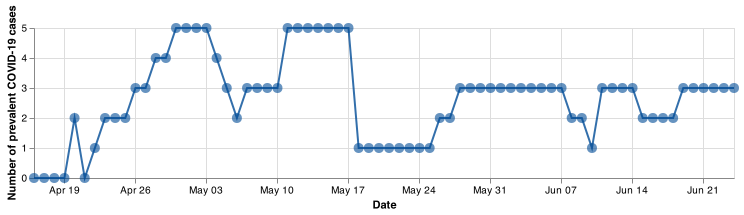

In [15]:
figure1=myhospital|> @vlplot(
        width=700, height=150,
        mark={:line, point={filled=true, size=100, color="#004b96", opacity = 0.6}, color="#004b96", opacity=0.8}, 
        x={field=:date, axis={title="Date"}},
        y={field=:currentcases, axis={title="Number of prevalent COVID-19 cases"}}
) 

## Fit the increment model for all hospitals individually

Next, we show how to optimize the increment model and all benchmark models discussed in the manuscript for all hospitals.

First, let's define the loss function, including a loop and control flow elements to automatically bridge missing reports by carrying the current model prediction forwards in time, until a new observation becomes available. 

In [16]:
function loss(y, z, r, beta)
    sqerror = 0.0 # squared error
    firstseen = false # set to true after skipping potential missings 
    last_y = 0.0 # prevalent cases from previous time point
    contribno = 0.0 # number of non-missing observations

    for t = 1:length(y)
        # skip missings at the start until first reported value
        if !firstseen 
            if r[t] == 1
                firstseen = true
                last_y = y[t]
            else
                continue
            end
        else # make a prediction for the current increment
            pred_dy = beta[1] + beta[2] * last_y + beta[3] * z[t-1] 
            if r[t] == 1
                dy = y[t] - last_y
                sqerror += (dy - pred_dy)^2
                contribno += 1.0
                last_y = y[t]
            else
                last_y += pred_dy
            end 
        end
    end
    return sqerror/contribno # return MSE over all reported time points end
end

loss (generic function with 1 method)

For each hospital, we need to extract the necessary data, i.e., the numbers of prevalent cases and predicted incidences used as covariates and the information on whether or not a report was missing. 

We set aside the last time point in the data to evaluate our prediction on: 

Then, we can use differentiable programming to optimize the model parameters by optimizing this loss function via gradient descent!

In [17]:
y, z, r = hospital_list[40][1:end-1,:currentcases], hospital_list[40][1:end-1,:incidences], hospital_list[40][1:end-1,:reported]
last_currentcases, lastreported = hospital_list[40][end,:currentcases], hospital_list[40][end,:reported]

(3.0, false)

In [20]:
beta = [0.0, 0.0, 0.0]
losses = []
@time for epoch=1:1000
    curgrad = gradient(arg -> loss(y, z, r, arg), beta)
    beta .-= [0.001, 0.01, 0.001] .* curgrad[1]
    push!(losses, loss(y, z, r, beta))
end

  0.853632 seconds (4.81 M allocations: 241.651 MiB, 7.80% gc time, 10.38% compilation time)


Let's visualize the loss!

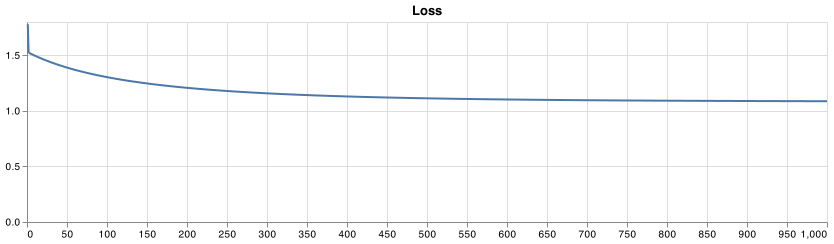

In [29]:
@vlplot(:line, x = {collect(1:1000), type="quantitative"}, y={losses, type="quantitative"}, width=800, title="Loss")

Now, we can do this for all hospitals, and compare the different benchmark models and their prediction errors. 

For this, we first initialize the parameters `betas` and `lrbetas` for both the increment model and the standard linear regression model estimated via classical maximum likelihood. 

In [37]:
nhospitals = length(hospital_list)

betas = collect([0.0; 0.0; 0.0] for i in 1:nhospitals)
lrbetas = collect([0.0; 0.0; 0.0] for i in 1:nhospitals);

For each model, we also initialize an array for the predictions from this model for each hospital.  

In [38]:
prederrs_mean = Array{Union{Float64, Missing}}(missing, nhospitals)
prederrs_modmean = Array{Union{Float64, Missing}}(missing, nhospitals)
prederrs_zero = Array{Union{Float64, Missing}}(missing, nhospitals)
prederrs_linreg = Array{Union{Float64, Missing}}(missing, nhospitals)
prederrs_incrmod = Array{Union{Float64, Missing}}(missing, nhospitals);

Now, we optimize our model for all hospitals and compare the predictions to the baseline models.

In [39]:
@time for i = 1:nhospitals
    # get the covariates and info about missing reports
    y, z, r = hospital_list[i][1:end-1,:currentcases], hospital_list[i][1:end-1,:incidences], hospital_list[i][1:end-1,:reported]
    last_currentcases, lastreported = hospital_list[i][end,:currentcases], hospital_list[i][end,:reported]

    # run the gradient descent via automatic differentiation/differentiable programming
    beta = betas[i]
    for epoch=1:150
        curgrad = gradient(arg -> loss(y, z, r, arg), beta)
        beta .-= [0.001, 0.01, 0.001] .* curgrad[1]
    end
    betas[i] = beta

    # calculate last increment based on the held-out final time point 
    lastincr = last_currentcases - y[end]

    # calculate the prediction of the fitted models for this last increment
    incrmod_pred = beta[1] + beta[2] * y[end] + beta[3] * z[end]

    # calculate the prediction of the mean and modified mean models
    mean_pred = mean(diff(y))
    modmean_pred = y[end] == 0.0 ? 0.0 : mean_pred

    # coarse heuristic: if the fit goes wrong, use the mean model prediction as fallback
    if isnan(incrmod_pred) || any(abs.(beta) .> 10)
        incrmod_pred = mean_pred
    end

    # fit standard linear regression model using the last-observation-carried-forward imputation in the :currentcases
    slrdf = DataFrame(dy = diff(y), y = y[2:end], z = z[2:end])
    ols = lm(@formula(dy ~ y + z), slrdf) # standard estimation using maximum likelihood
    lrbeta = coef(ols) 
    lrbetas[i] = lrbeta
    # calculate prediction of the standard linear regression model for the last increment 
    linreg_pred = lrbeta[1] + lrbeta[2] * y[end] + lrbeta[3] * z[end]

    # include in the prediction error array only if the value at the last time point has actually been reported
    if lastreported 
        prederrs_mean[i] = (lastincr - mean_pred)^2
        prederrs_modmean[i] = (lastincr - modmean_pred)^2
        prederrs_zero[i] = (lastincr - 0)^2
        prederrs_linreg[i] = (lastincr - linreg_pred)^2
        prederrs_incrmod[i] = (lastincr - incrmod_pred)^2
    end
    if i%40 == 0
        println("currently at hospital $i...")
    end
end

currently at hospital 20...


currently at hospital 40...


currently at hospital 60...


currently at hospital 80...


currently at hospital 100...


currently at hospital 120...


currently at hospital 140...


currently at hospital 160...


currently at hospital 180...


currently at hospital 200...


currently at hospital 220...


currently at hospital 240...


currently at hospital 260...


currently at hospital 280...


currently at hospital 300...


currently at hospital 320...


currently at hospital 340...


currently at hospital 360...


currently at hospital 380...


currently at hospital 400...


currently at hospital 420...


currently at hospital 440...


currently at hospital 460...


currently at hospital 480...


currently at hospital 500...


currently at hospital 520...


currently at hospital 540...


currently at hospital 560...


currently at hospital 580...


currently at hospital 600...


currently at hospital 620...


currently at hospital 640...


currently at hospital 660...


currently at hospital 680...


currently at hospital 700...


currently at hospital 720...


currently at hospital 740...


currently at hospital 760...


currently at hospital 780...


currently at hospital 800...


currently at hospital 820...


currently at hospital 840...


currently at hospital 860...


currently at hospital 880...


currently at hospital 900...


currently at hospital 920...


currently at hospital 940...


currently at hospital 960...


currently at hospital 980...


currently at hospital 1000...


currently at hospital 1020...


currently at hospital 1040...


currently at hospital 1060...


currently at hospital 1080...


currently at hospital 1100...


currently at hospital 1120...


currently at hospital 1140...


currently at hospital 1160...


currently at hospital 1180...


currently at hospital 1200...


currently at hospital 1220...


currently at hospital 1240...


currently at hospital 1260...


currently at hospital 1280...
 77.075455 seconds (1.21 G allocations: 59.196 GiB, 15.16% gc time, 0.11% compilation time)


We can now combine the prediction errors for all models in a dataframe and calculate summary statistics. 

In [40]:
nonmissinginds = findall(x -> !ismissing(x), prederrs_mean)
prederrs_df = DataFrame(hospitals = nonmissinginds,
                meanmodel = Float64.(prederrs_mean[nonmissinginds]),
                modmeanmodel = Float64.(prederrs_modmean[nonmissinginds]),
                zeromodel = Float64.(prederrs_zero[nonmissinginds]),
                linregmodel = Float64.(prederrs_linreg[nonmissinginds]),
                incrmodel = Float64.(prederrs_incrmod[nonmissinginds])
)
models = names(prederrs_df[!,2:end])
summed_squared_errors = sum.(eachcol(prederrs_df[!,2:end]))
mses = round.(sum.(eachcol(prederrs_df[!,2:end]))./(nrow(prederrs_df)), digits=3)
medians = round.(median.(eachcol(prederrs_df[!,2:end])), digits=3)
firstquartile = round.(quantile.(eachcol(prederrs_df[!,2:end]), 0.25), digits=3)
thirdquartile = round.(quantile.(eachcol(prederrs_df[!,2:end]), 0.75), digits=3)
maxvals = round.(maximum.(eachcol(prederrs_df[!,2:end])), digits=3)
summary_df = DataFrame(Model = models, 
                    SSE = summed_squared_errors, MSE = mses, 
                    FirstQuartile = firstquartile,
                    Median = medians, 
                    ThirdQuartile = thirdquartile,
                    Maximum = maxvals
)

,Model,SSE,MSE,FirstQuartile,Median,ThirdQuartile,Maximum
,String,Float64,Float64,Float64,Float64,Float64,Float64
1,meanmodel,89.2388,0.072,0.0,0.0,0.002,9.0
2,modmeanmodel,84.3421,0.069,0.0,0.0,0.0,9.0
3,zeromodel,86.0,0.07,0.0,0.0,0.0,9.0
4,linregmodel,181.068,0.147,0.0,0.001,0.015,30.227
5,incrmodel,74.7457,0.061,0.0,0.0,0.001,6.079


## Recovering censored values 

First, we need to find all hospitals with complete reporting: 

In [41]:
allreported_inds = findall(i -> sum(hospital_list[i][!,:notreported])== 0, 1:nhospitals)

463-element Vector{Int64}:
    2
    5
   13
   17
   19
   20
   23
   26
   27
   34
    ⋮
 1257
 1259
 1260
 1265
 1268
 1269
 1272
 1275
 1279

Now, we can randomly censor different fractions of reports, fir all prediction models, and look at the corresponding prediction. 

We load some convenience functions for that first: 

In [42]:
include(string(@__DIR__, "/../src/evaluate.jl"))
include(string(@__DIR__, "/../src/lov.jl"))

fitmodels_lov (generic function with 1 method)

In [43]:
# initialize array to save prediction errors
prederrs_df_all = []

# fit prediction models (all local coefficients) 
for frac_missing in [0.1, 0.25, 0.5, 0.75] 

    @info "Starting scenario with $(frac_missing) percent random censoring"

    betas = collect([0.0; 0.0; 0.0] for ind in 1:length(allreported_inds));
    lrbetas = collect([0.0; 0.0; 0.0] for ind in 1:length(allreported_inds));

    prederrs_mean = []
    prederrs_modmean = []
    prederrs_zero = []
    prederrs_lr = []
    prederrs_incr = []

    Random.seed!(42);
    nreps = 100

    for ind in 1:length(allreported_inds)
        i = allreported_inds[ind]
        true_y, z, r = hospital_list[i][:,:currentcases], hospital_list[i][:,:incidences], hospital_list[i][:,:reported]
        
        prederr_incr = 0.0
        prederr_lr = 0.0
        prederr_zero = 0.0
        prederr_mean = 0.0
        prederr_modmean = 0.0
        
        mod_r = modify_r_wrapper(frac_missing)

        prederr_mean, prederr_modmean, prederr_zero, prederr_lr, prederr_incr, betas_reps, lrbetas_reps = fitmodels_lov(hospital_list, i, nreps, mod_r)

        betas[ind] = [mean(collect(betas_reps[rep][1] for rep in 1:nreps)); mean(collect(betas_reps[rep][2] for rep in 1:nreps)); mean(collect(betas_reps[rep][3] for rep in 1:nreps))]
        lrbetas[ind] = [mean(collect(lrbetas_reps[rep][1] for rep in 1:nreps)); mean(collect(lrbetas_reps[rep][2] for rep in 1:nreps)); mean(collect(lrbetas_reps[rep][3] for rep in 1:nreps))]
        
        push!(prederrs_mean, prederr_mean/nreps)
        push!(prederrs_modmean, prederr_modmean/nreps)
        push!(prederrs_zero, prederr_zero/nreps)
        push!(prederrs_lr, prederr_lr/nreps)
        push!(prederrs_incr, prederr_incr/nreps)
        if ind % 20 == 0
            @info "currently at hospital $i..."
        end
    end

    prederrs_df = create_prederrs_df(prederrs_mean, prederrs_modmean, prederrs_zero, prederrs_lr, prederrs_incr)
    push!(prederrs_df_all, prederrs_df)
end

┌ Info: Starting scenario with 0.1 percent random censoring
└ @ Main /Users/imbi-mac-102/Desktop/TalkReisensburg/DifferentiableProgrammingForStatisticalModeling-main/notebooks/DifferentiableProgrammingDemo.ipynb:7
┌ Info: currently at hospital 45...
└ @ Main /Users/imbi-mac-102/Desktop/TalkReisensburg/DifferentiableProgrammingForStatisticalModeling-main/notebooks/DifferentiableProgrammingDemo.ipynb:44


┌ Info: currently at hospital 123...
└ @ Main /Users/imbi-mac-102/Desktop/TalkReisensburg/DifferentiableProgrammingForStatisticalModeling-main/notebooks/DifferentiableProgrammingDemo.ipynb:44
┌ Info: currently at hospital 164...
└ @ Main /Users/imbi-mac-102/Desktop/TalkReisensburg/DifferentiableProgrammingForStatisticalModeling-main/notebooks/DifferentiableProgrammingDemo.ipynb:44


InterruptException: InterruptException:

To save some time, this has been pre-run and the output saved, we will load it now to proceed: 

In [44]:
prederrs_dict = load(string(@__DIR__, "/../results/randomcensoring_prederrs.jld2"))
prederrs_df_all = prederrs_dict["all_prederrs_dfs"]

4-element Vector{Any}:
 463×6 DataFrame
 Row │ hospitals  meanmodel   modmeanmodel  zeromodel   linregmodel  incrmodel ⋯
     │ Int64      Float64     Float64       Float64     Float64      Float64   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │         1  0.00505596    0.00509359  0.00507246   0.00642406  0.0045795 ⋯
   2 │         2  0.0           0.0         0.0          0.0         0.0
   3 │         3  0.00432713    0.00427389  0.00434783   0.00549594  0.0039592
   4 │         4  0.0853478     0.0829677   0.0873913    0.13319     0.0778724
   5 │         5  0.0           0.0         0.0          0.0         0.0       ⋯
   6 │         6  0.0242986     0.0240558   0.0243478    0.0333819   0.0219075
   7 │         7  0.00275362    0.00275362  0.00275362   0.00440538  0.0025207
   8 │         8  0.00652174    0.00652174  0.00652174   0.00837991  0.0056166
  ⋮  │     ⋮          ⋮            ⋮            ⋮            ⋮           ⋮     ⋱
 457 │

From that, we can create a dataframe of summary statistics: 

In [45]:
nmodels = 5
nscenarios= 4
mses = []
medians = []
firstquartiles = []
thirdquartiles = []
maximums = []
for i in 1:nscenarios 
    cur_pred_df = prederrs_df_all[i]
    push!(mses, round.(sum.(eachcol(cur_pred_df[!,2:end]))/nrow(cur_pred_df), digits = 3))
    push!(medians,round.(median.(eachcol(cur_pred_df[!,2:end])), digits = 3))
    push!(firstquartiles, round.(quantile.(eachcol(cur_pred_df[!,2:end]), 0.25), digits = 3))
    push!(thirdquartiles, round.(quantile.(eachcol(cur_pred_df[!,2:end]), 0.75), digits = 3))
    push!(maximums, round.(maximum.(eachcol(cur_pred_df[!,2:end])), digits=3))
end

summary_df = DataFrame(Scenario = repeat(["$(i)" for i in 1:nscenarios], inner=nmodels),
                    Model = repeat(["Mean model", "Modified mean model", "Zero model", "Linear regression", "Increment model"], nscenarios),
                    MSE = cat(mses..., dims=1),
                    FirstQuartile = cat(firstquartiles..., dims=1),
                    Median = cat(medians..., dims=1),
                    ThirdQuartile = cat(thirdquartiles..., dims=1),
                    Maximum = cat(maximums..., dims=1)
)

,Scenario,Model,MSE,FirstQuartile,Median,ThirdQuartile,Maximum
,String,String,Float64,Float64,Float64,Float64,Float64
1,1,Mean model,0.042,0.002,0.011,0.035,2.821
2,1,Modified mean model,0.042,0.002,0.011,0.035,2.821
3,1,Zero model,0.043,0.002,0.011,0.035,2.848
4,1,Linear regression,0.06,0.003,0.015,0.049,3.949
5,1,Increment model,0.043,0.002,0.009,0.03,2.821
6,2,Mean model,0.116,0.006,0.031,0.097,6.55
7,2,Modified mean model,0.115,0.006,0.03,0.094,6.55
8,2,Zero model,0.117,0.006,0.032,0.098,6.578
9,2,Linear regression,0.179,0.007,0.046,0.144,10.034


## Comparing loss function optima

Finally, let's look at the different optima of the loss function for the classical maximun likelihood estimation based on the missing values imputed by last-observation-carried-forward, vs. the flexibel loss function bridging gaps of missing reports. 

First, we define the loss function for the LOCF + linear regression model 

In [46]:
function loss_locflinreg(dy, y, z, beta)
    dy_hat = beta[1] .+ y .* beta[2] .+ z .* beta[3]
    val = sum((dy_hat .- dy).^2)/length(y)
    return val 
end 

loss_locflinreg (generic function with 1 method)

Now, we look at one exemplary hospital, and compare the loss values. 

First, we fit the increment model: 

In [67]:
i=124

y, z, r = hospital_list[i][1:end-1,:currentcases], hospital_list[i][1:end-1,:incidences], hospital_list[i][1:end-1,:reported]
last_currentcases, lastreported = hospital_list[i][end,:currentcases], hospital_list[i][end,:reported]
lastincr = last_currentcases - y[end]

0.0

In [69]:
beta = [0.0, 0.0, 0.0]

for epoch=1:150
    curgrad = gradient(arg -> loss(y, z, r, arg), beta)
    beta .-= [0.001, 0.01, 0.001] .* curgrad[1]
end
@info "optimal beta:" beta

incrmod_pred = beta[1] + beta[2] * y[end] + beta[3] * z[end]
@info "Model prediction:" incrmod_pred

┌ Info: optimal beta:
│   beta = [0.009673814357481405, -0.19765998134203303, 0.19940676708379262]
└ @ Main /Users/imbi-mac-102/Desktop/TalkReisensburg/DifferentiableProgrammingForStatisticalModeling-main/notebooks/DifferentiableProgrammingDemo.ipynb:7
┌ Info: Model prediction:
│   incrmod_pred = 0.0013505583615094907
└ @ Main /Users/imbi-mac-102/Desktop/TalkReisensburg/DifferentiableProgrammingForStatisticalModeling-main/notebooks/DifferentiableProgrammingDemo.ipynb:10


Let's look at the baseline predictions first: 

In [70]:
mean_pred = mean(diff(y))
modmean_pred = y[end] == 0.0 ? 0.0 : mean_pred

@info "mean_pred:" mean_pred
@info "modified mean pred:" modmean_pred

┌ Info: mean_pred:
│   mean_pred = -0.17647058823529413
└ @ Main /Users/imbi-mac-102/Desktop/TalkReisensburg/DifferentiableProgrammingForStatisticalModeling-main/notebooks/DifferentiableProgrammingDemo.ipynb:4
┌ Info: modified mean pred:
│   modmean_pred = -0.17647058823529413
└ @ Main /Users/imbi-mac-102/Desktop/TalkReisensburg/DifferentiableProgrammingForStatisticalModeling-main/notebooks/DifferentiableProgrammingDemo.ipynb:5


Now, let's compare the linear regression prediction. 

In [71]:
slrdf = DataFrame(dy = diff(y), y = y[2:end], z = z[2:end])
ols = lm(@formula(dy ~ y + z), slrdf)
lrbeta = coef(ols)
linreg_pred = lrbeta[1] + lrbeta[2] * y[end] + lrbeta[3] * z[end]

@info "beta from LOCF + linear regression:" lrbeta
@info "LOCF + linear regression prediction:" linreg_pred

┌ Info: beta from LOCF + linear regression:
│   lrbeta = [-0.13840695572446282, -0.011359847548439458, 0.0040478295996681]
└ @ Main /Users/imbi-mac-102/Desktop/TalkReisensburg/DifferentiableProgrammingForStatisticalModeling-main/notebooks/DifferentiableProgrammingDemo.ipynb:6
┌ Info: LOCF + linear regression prediction:
│   linreg_pred = -0.14592338906801744
└ @ Main /Users/imbi-mac-102/Desktop/TalkReisensburg/DifferentiableProgrammingForStatisticalModeling-main/notebooks/DifferentiableProgrammingDemo.ipynb:7


Finally, we can compare the loss function values at the optimal coefficients:

In [72]:
loss_lr = loss_locflinreg(diff(y), y[2:end], z[2:end], lrbeta)
@info "loss from LOCF + linear regression:" loss_lr
loss_incr = loss(y, z, r, beta)
@info "loss from increment model:" loss_incr

┌ Info: loss from LOCF + linear regression:
│   loss_lr = 0.37951482642455703
└ @ Main /Users/imbi-mac-102/Desktop/TalkReisensburg/DifferentiableProgrammingForStatisticalModeling-main/notebooks/DifferentiableProgrammingDemo.ipynb:2
┌ Info: loss from increment model:
│   loss_incr = 0.32782053612611106
└ @ Main /Users/imbi-mac-102/Desktop/TalkReisensburg/DifferentiableProgrammingForStatisticalModeling-main/notebooks/DifferentiableProgrammingDemo.ipynb:4
